In [ ]:
!pip install opencv-python numpy
from IPython.display import display, Image, clear_output
import cv2
import numpy as np


In [ ]:

!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


--2024-11-16 21:25:31--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg.1’

yolov3.cfg.1        100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-11-16 21:25:31 (60.8 MB/s) - ‘yolov3.cfg.1’ saved [8342/8342]

--2024-11-16 21:25:31--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  26.4MB/s    in 8.3s    

2024-11-1

In [ ]:

video_path = '/content/Video.mp4'
cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))


In [ ]:

vehicle_count = 0

def is_vehicle(label):
    return label in ["car", "bus", "truck", "motorbike"]

def detect_and_count(frame, net, output_layers, conf_threshold=0.5, nms_threshold=0.4):
    global vehicle_count
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)

    outs = net.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > conf_threshold and is_vehicle(classes[class_id]):
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    detected_vehicles = 0

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]

            color = (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {int(confidence * 100)}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            detected_vehicles += 1

    vehicle_count += detected_vehicles
    return frame, detected_vehicles


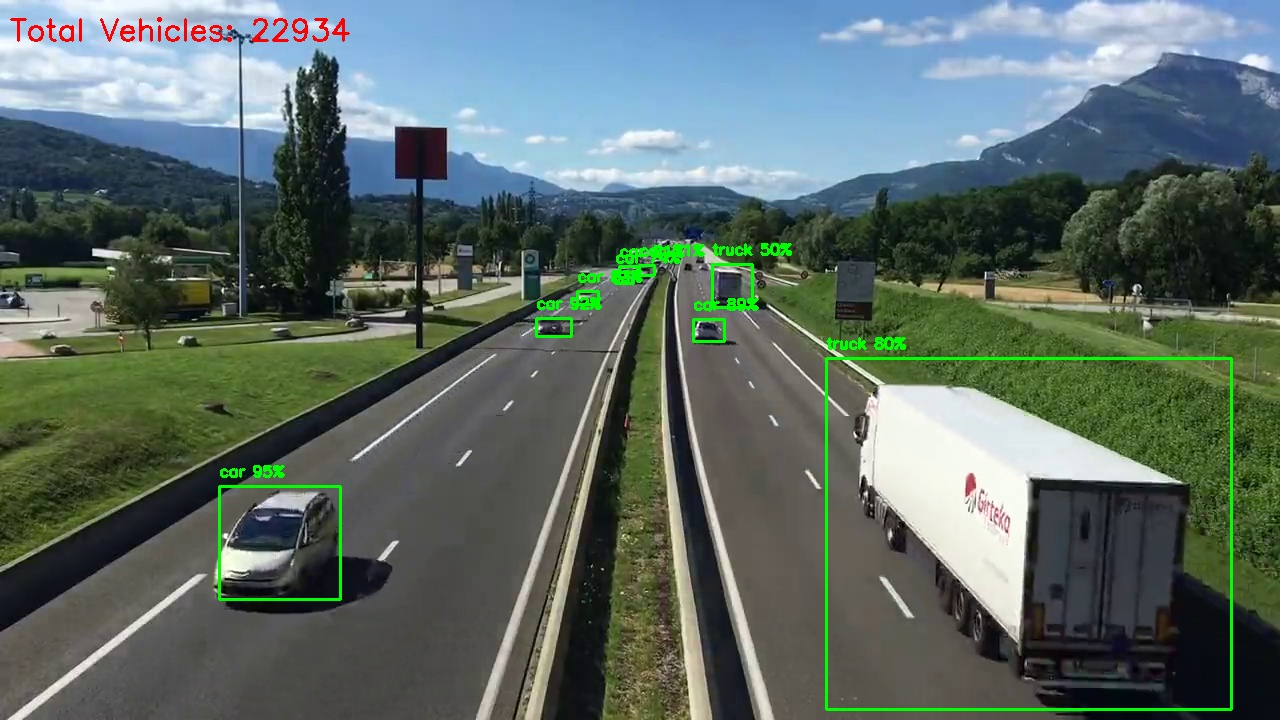

In [ ]:

from IPython.display import display, clear_output, Image
import cv2
import numpy as np

while True:
    ret, frame = cap.read()

    if not ret:
        break
    frame, detected_vehicles = detect_and_count(frame, net, output_layers)

    cv2.putText(frame, f"Total Vehicles: {vehicle_count}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    out.write(frame)

    _, img_encoded = cv2.imencode('.jpg', frame)
    clear_output(wait=True)
    display(Image(data=img_encoded.tobytes()))

cap.release()
out.release()
cv2.destroyAllWindows()

from google.colab import files
files.download('output.avi')
